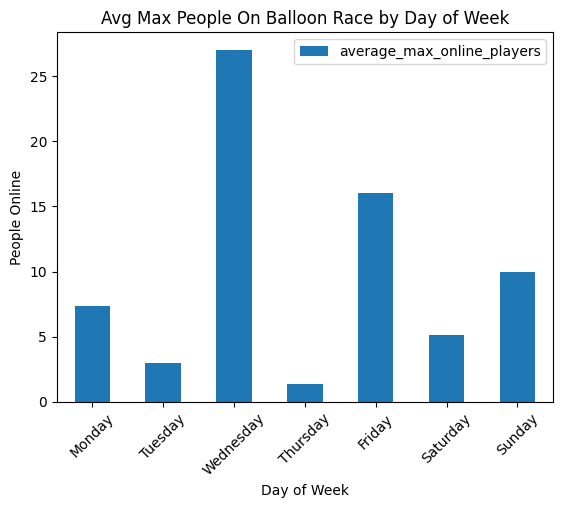

In [4]:
# find out when people are on

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df = pd.read_csv('tf2_balloon_log.txt', header=None)

df['date'] = df[0].str.slice(0, 10)
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.day_name()
df['hour'] = df[0].str.slice(11, 13).astype(int)
df['month'] = df['date'].dt.month_name()
df['hour'] = df['hour'].apply(
    lambda x: f"{x % 12 if x % 12 != 0 else 12}{' AM' if x < 12 else ' PM'}"
)

df['online_players'] = (df[0]
    .str.extract(r':\s*(\d+)$', expand=False)
    .fillna(0)  # Replace NaN with 0 (or another default value)
    .astype(int)  # Convert to integer
)

df['server_name'] = df.query('online_players > 0')[0].str.extract(r'- INFO - ([^:]+) :').fillna(0)

graph_df = df.iloc[:, 1:]

day_of_week_avg = (
    graph_df.groupby(['date', 'day_of_week'])['online_players']  # Step 1: Group by date and day_of_week
    .max()  # Get the daily maximum
    .groupby('day_of_week')  # Step 2: Group by day_of_week
    .mean()  # Calculate the average of daily maximums
    .reset_index(name='average_max_online_players')  # Reset the index and rename the column
)

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week_avg['day_of_week'] = pd.Categorical(day_of_week_avg['day_of_week'], categories=day_order, ordered=True)
day_of_week_avg = day_of_week_avg.sort_values('day_of_week')


plot = day_of_week_avg.plot(
    x='day_of_week', y='average_max_online_players', kind='bar'
)
plt.xticks(rotation=45)
plt.ylabel('People Online') 
plt.xlabel('Day of Week') 

plt.title('Avg Max People On Balloon Race by Day of Week')
plt.show()

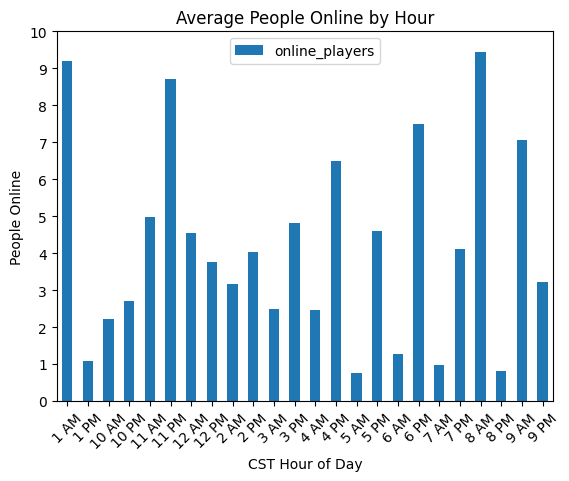

In [26]:
hourly_avg = (
    graph_df.groupby(['date', 'hour'])['online_players']  # Group by date and hour
    .sum()  # Get the daily maximum for each hour
    .groupby('hour')  # Group by hour
    .mean()  # Calculate the average of daily maximums for each hour
    .reset_index(name='online_players')  # Reset index and rename column
)

plot = hourly_avg.plot(
    x='hour', y='online_players', kind='bar'
)
plt.xticks(rotation=45)
plt.ylabel('People Online') 
plt.xlabel('CST Hour of Day') 

max_value = hourly_avg['online_players'].max()
plt.yticks(np.arange(0, np.ceil(max_value) + 1, 1))
plt.title('Average People Online by Hour')
plt.show()


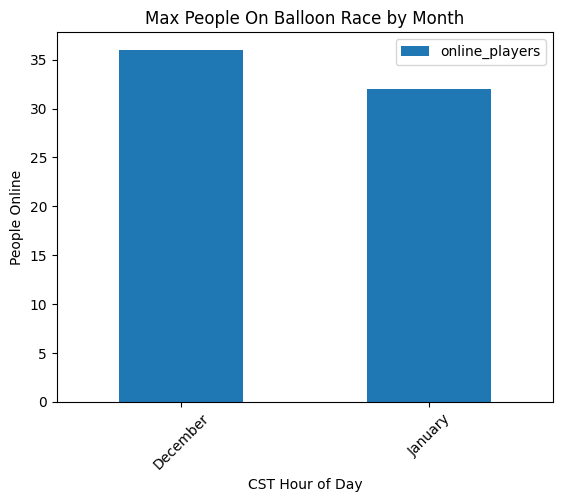

In [8]:
monthly_avg = (
    graph_df.groupby('month')['online_players'].max()
).reset_index(name='online_players')


plot = monthly_avg.plot(
    x='month', y='online_players', kind='bar'
)
plt.xticks(rotation=45)
plt.ylabel('People Online') 
plt.xlabel('CST Hour of Day') 

max_value = monthly_avg['online_players'].max()
# plt.yticks(np.arange(0, np.ceil(max_value) + 1, 1))
plt.title('Max People On Balloon Race by Month')
plt.show()


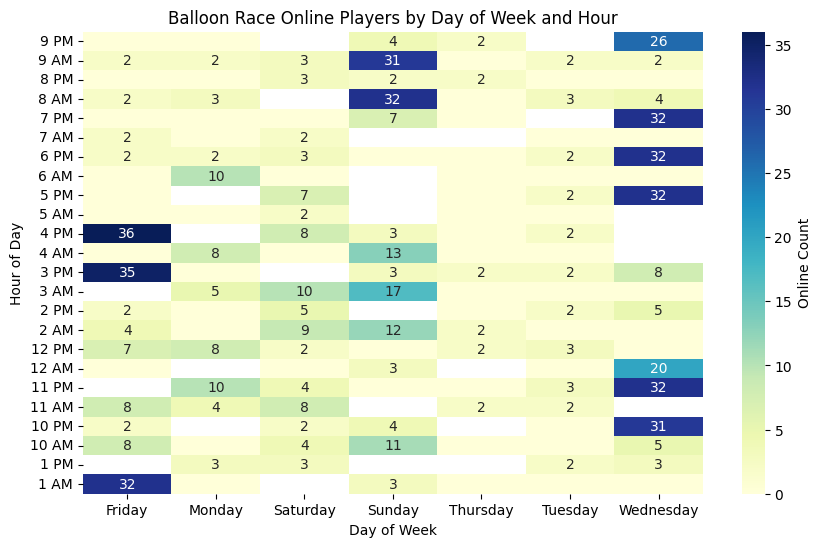

In [ ]:


# Pivot the data to have 'hour' as columns and 'day_of_week' as rows
heatmap_data = graph_df.pivot_table(
    index='hour',
    columns='day_of_week',
    values='online_players', 
    aggfunc='max',  # You can use sum, mean, or another aggregation function
    fill_value=0  # Fill missing values with 0 (or another value)
)

# Reverse the hour index
heatmap_data = heatmap_data.iloc[::-1]

# Create a mask where values are 0 (to make those cells white)
mask = heatmap_data == 1

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt="d", cbar_kws={'label': 'Online Count'}, mask=mask)

# Replace 0 with empty strings in the annotations
for text in plt.gca().texts:
    if text.get_text() == "0":
        text.set_text("")  # Set empty string for 0 values

# Add labels and title
plt.title('Max Balloon Race Online Players by Day of Week and Hour')
plt.ylabel('Hour of Day')
plt.xlabel('Day of Week')

# Show the plot
plt.show()


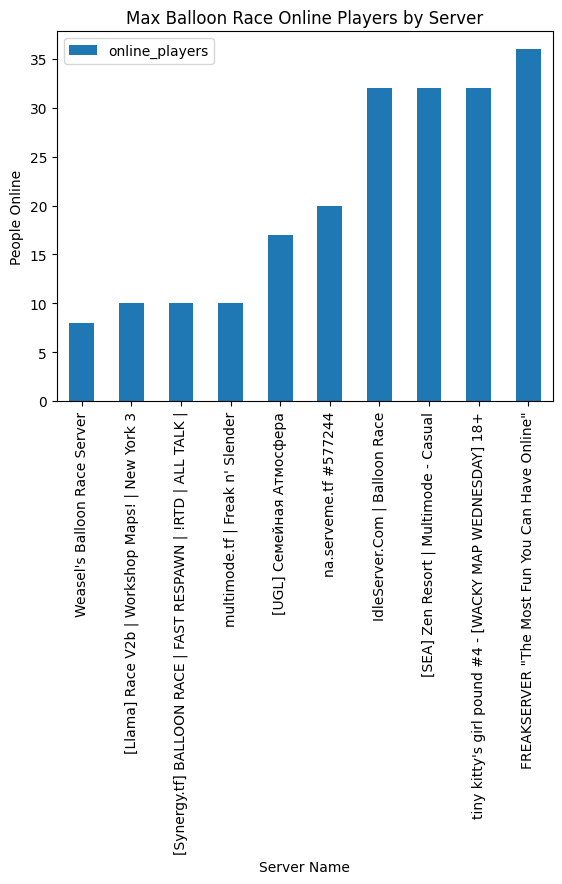

In [9]:
# list top servers as well and what time and day people play on them

# bar graph of top server names by player count

plot = (
    graph_df.query('online_players > 0')
    .groupby(['server_name'])['online_players']
    .max()
    .sort_values(ascending=False)  # Sort values in descending order (largest at the top)
    .reset_index()
    .head(10)
    .iloc[::-1]  # Reverse the order to have the largest bar on top
    .plot(
        x='server_name', y='online_players', kind='bar'
    )
)
plt.xticks(rotation=90)
plt.ylabel('People Online') 
plt.xlabel('Server Name')

plt.title('Max Balloon Race Online Players by Server')
plt.savefig('charts/top_servers.png', dpi=300, bbox_inches='tight')